# 行为克隆

behavior cloning，BC

## 导包

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import rl_utils
import numpy as np
import random
from tqdm import tqdm

## 网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## PPO算法

In [3]:
class PPO:
    ''' PPO算法, 采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用于训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones | truncated)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

## 读取专家模型

In [4]:
# PPO相关
actor_lr = 1e-3
critic_lr = 1e-2
lmbda = 0.95  # 似乎可以去掉，这一项仅用于调整计算优势advantage时，额外调整折算奖励的系数
gamma = 0.98  # 时序差分学习率，也作为折算奖励的系数之一
total_epochs = 10  # 迭代轮数
total_episodes = 500  # 一轮训练多少次游戏

eps = 0.2  # 截断范围参数, 1-eps ~ 1+eps
epochs = 10  # PPO中一条序列训练多少轮，和迭代算法无关
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device:', device)

# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
hidden_dim = 128
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, lmbda, epochs, eps, device)

device: cuda


In [6]:
ckp_path = 'checkpoints/PPO_CPv1.pt'
checkpoint = torch.load(ckp_path)
agent.actor.load_state_dict(checkpoint['actor_best_weight'])

<All keys matched successfully>

In [ ]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for _ in range(n_episode):
        state = env.reset()[0]
        done = truncated = False
        while not done:
            action = agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
    return np.array(states), np.array(actions)

env = gym.make('CartPole-v1', render_mode='rgb_array')
torch.manual_seed(0)
random.seed(0)
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 500  # 采样数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

## 行为克隆

In [17]:
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1).to(device)
        log_probs = torch.log(self.policy(states).gather(1, actions))
        bc_loss = torch.mean(-log_probs)  # 最大似然估计

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()


def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state = env.reset()[0]
        done = truncated = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)

torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 1000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条", leave=False) as pbar:
    for i in range(n_iterations):
        # 创建一个乱序
        sample_indices = np.random.randint(low=0, high=expert_s.shape[0], size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        # 收集reward
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

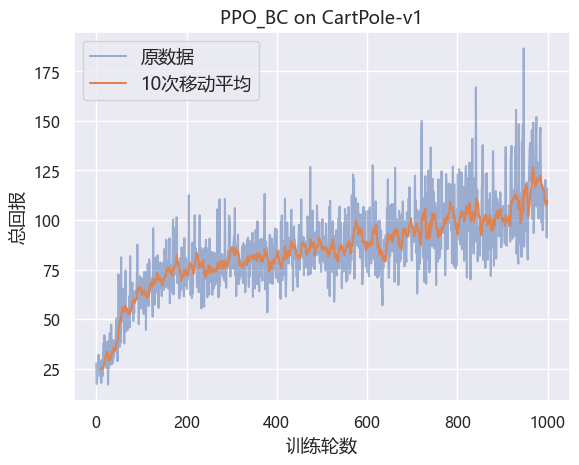

In [18]:
rl_utils.picture_return(test_returns, 'PPO_BC', env_name)

## 评价

行为克隆效果一般不会很好，因为每次环境反馈的不会完全一样，只有在专家碰到过的那个行为分布上，才会有比较好的效果，一旦碰到专家没碰到过的情况，智能体就只能随机选择动作，可能会有比较大的错误，这种错误会一直积累，所以泛化性很差。

用一个专家轨迹作为labels，训练方法和深度学习一样，专家可以是人，也可以是训练好的模型

# 生成对抗模仿学习

generative adversarial imitation learning，GAIL

前面还是要写PPO算法并且定义agent, 还要生成专家数据，存储专家状态和动作表

agent还是要自己和环境交互的

## 判别器网络

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        # 输出的是概率
        return torch.sigmoid(self.fc2(x))

## GAIL算法

In [9]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d):
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones, truncated):
        expert_states = torch.tensor(np.array(expert_s), dtype=torch.float).to(device)
        expert_actions = torch.tensor(np.array(expert_a), dtype=torch.int64).to(device)
        agent_states = torch.tensor(np.array(agent_s), dtype=torch.float).to(device)
        agent_actions = torch.tensor(np.array(agent_a), dtype=torch.int64).to(device)
        # 把动作分为两类的独热编码
        expert_actions = F.one_hot(expert_actions, num_classes=2).float()
        agent_actions = F.one_hot(agent_actions, num_classes=2).float()

        expert_prob = self.discriminator(expert_states, expert_actions)  # 专家状态动作打分
        agent_prob = self.discriminator(agent_states, agent_actions)  # agent状态动打分
        # * 二元交叉熵损失 BCELoss, 专家轨迹label为0, agent轨迹label为1, 越靠近0, 代表该轨迹越接近专家轨迹
        # * 这里让目标函数梯度下降, 可以让agent与环境交互的行为分布接近专家的交互分布
        # * 也就是让agent生成的状态动作接近轨迹
        discriminator_loss = torch.nn.BCELoss()(agent_prob, torch.ones_like(agent_prob)) \
            + torch.nn.BCELoss()(expert_prob, torch.zeros_like(expert_prob))
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        # agent_prob是判别器把agent识别为模仿者的概率, 所以可以让这个概率越小越好, 因此就加负号, 变成奖励
        # 这样在训练演员的时候, 就可以引导演员往降低agent_prob的方向调整
        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'truncated': truncated,
            'dones': dones
        }
        self.agent.update(transition_dict)

torch.manual_seed(0)
lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()[0]
        done = truncated = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        truncated_list = []
        while not (done | truncated):
            action = agent.take_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            truncated_list.append(truncated)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list,
                   next_state_list, done_list, truncated_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 500/500 [03:47<00:00,  2.20it/s, return=500.000]


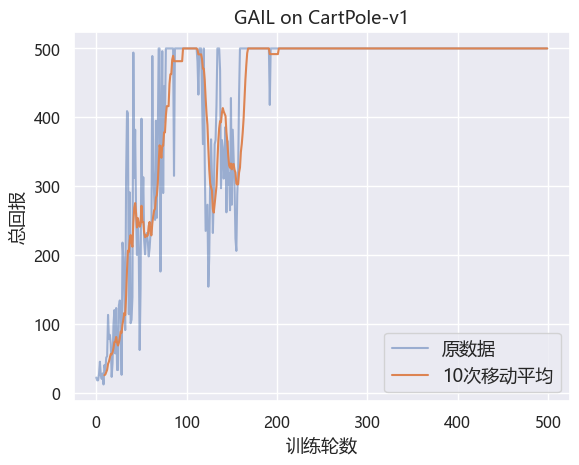

In [11]:
rl_utils.picture_return(return_list, 'GAIL', env_name)